# 2D DC Resistivity Sensitivity analysis

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Williams Lima

</br>

**Keywords:** DC Resistivity inversion, sensitivity matrix.

</br>

**Summary:**
The sensitivity matrix is a very important, and frequently used, tool to consider when designing a DC resistivity survey. It can give us qualitative and, to some extent, quantitave information about the capability of estimating the distribution of electrical conductivities underground using a particular experimental setup and geological environment. In this tutorial we'll use SimPEG functionalities to look at the sensitivity matrix for the DC resistivity inverse problem. We will analyse the sensitivity patterns for a few commonly used electrode arrays using a homogeneous conductivity model and also look at a real data case from a mineral exploration scenario. Enjoy!

</br>

**Learning Objectives:**

- How to get the sensitivity matrix for a DC resistivits simulation by using utility functions in SimPEG.
- Exploring the different sensitivity patterns for a number of common electrode arrays.
- How to plot information contained in the sensitivity matrix.
- Look at the sensitivity matrix for a real data set.

</br>

## Import modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity).

We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To simulate DC resistivity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG import maps

# discretize functionality
from discretize import TreeMesh, TensorMesh
from discretize.utils import refine_tree_xyz

# Common Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

from SimPEG.electromagnetics.static import utils as dc_utils

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

## Homogeneous half space

### Define surveys
There are many different possible combinations of current and potential electrodes locations that could be used to create a DC resistivity survey. Maybe some of those combinations would be better than others for a particular case under specific constraints such as cost, physical constraints, time and sensitivity to a particular target at depth. The sensitivity analysis, that we are going to perform in this tutorial, will help us with the task of assessing the performance of a given electrode array with respect to its sensitivity to conductivity anomalies around a particular target region in the subsurface. For more information about DC resistivity modeling in SimPEG check out the tutorial [2.5D DC Resistivity Simulation](05-dcr/fwd_dcr_2d).

In the figure below, we can see a few of the most common array configurations used in the industry and academic works.

```{figure}https://gpg.geosci.xyz/_images/figure6.gif
:width: 350px
:align: center

DC resistivity arrays ([image source](https://gpg.geosci.xyz/_images/figure6.gif))
```

**Two simple surveys in a homogeneous medium**

Our first step is to create two simple surveys, Wenner alpha and Wenner beta. Each of theses surveys will contain one pair of current electrodes and one pair of potential electrodes only. The extension to any number of current/potential electrodes is straightforward and will be left as an exercise.



In [2]:
# Define survey line parameters for Wenner surveys
data_type = "volt"
src_list = []

# Wenner alpha
C_wenner_alpha = np.array([[-15.0, 0.0], [15.0, 0.0]])
P_wenner_alpha = np.array([[-5.0, 0.0], [5.0, 0.0]])

rx_wenner_alpha = dc.receivers.Dipole(locations_m=P_wenner_alpha[0], locations_n=P_wenner_alpha[1], data_type=data_type) 
rx_list_wenner_alpha = [rx_wenner_alpha]

src_list.append(dc.sources.Dipole(location_a=C_wenner_alpha[0], location_b=C_wenner_alpha[1], receiver_list=rx_list_wenner_alpha))

# Dipole-Dipole
C_dipole_dipole = np.array([[-15.0, 0.0], [-5.0, 0.0]])
P_dipole_dipole = np.array([[5.0, 0.0], [15.0, 0.0]])

rx_dipole_dipole = dc.receivers.Dipole(locations_m=P_dipole_dipole[0], locations_n=P_dipole_dipole[1], data_type=data_type) 
rx_list_dipole_dipole = [rx_dipole_dipole]

src_list.append(dc.sources.Dipole(location_a=C_dipole_dipole[0], location_b=C_dipole_dipole[1], receiver_list=rx_list_dipole_dipole))

survey = dc.Survey(source_list=src_list)

### Create mesh

In [3]:
dh = 0.25  # base cell width
dom_width_x = 300.0  # domain width x
dom_width_z = 200.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Refine core mesh region
mesh.refine_box([-50,-50],[50,0], levels=-1, finalize=False)

mesh.finalize()

### Define the conductivity model

In [4]:
background_resistivity = 50 # Ohm.m
background_conductivity = 1/background_resistivity
nC = mesh.nC
conductivity_model = background_conductivity * np.ones(nC)

conductivity_map = maps.IdentityMap()

In [5]:
# DC simulation for a conductivity model
simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map
)

### Plot sensitivity

**Get the sensitivity matrix**

In [6]:
J = simulation_con.getJ(conductivity_model).copy()
J_wenner_alpha = J[0,:]/np.max(abs(J[0,:]))
J_dipole_dipole = J[1,:]/np.max(abs(J[1,:]))

**Make plots**

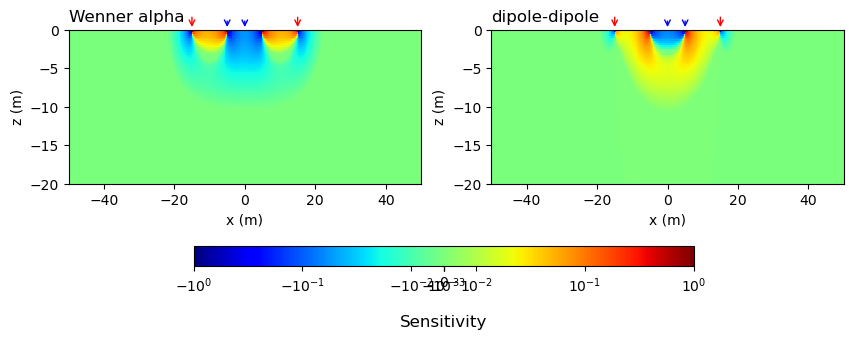

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,2))
plt.jet()

norm = mpl.colors.SymLogNorm(
    linthresh=0.005, linscale=1e-4,
    vmin=-1.0, vmax=1.0, base=10)

Js = np.c_[J_wenner_alpha, J_dipole_dipole] 
C_locs = np.r_[C_wenner_alpha, C_dipole_dipole]
P_locs = np.r_[P_wenner_alpha, P_dipole_dipole]

plt_titles = ["Wenner alpha", "dipole-dipole"]
i = 0
for ax in axs:    
    mesh.plot_image(
        Js[:,i],
        ax=ax,
        grid=False,
        pcolor_opts={"norm": norm}
    )
    
    xmin = -50; xmax = 50
    zmin = -20; zmax = 0
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(zmin, zmax)
    ax.set_title(plt_titles[i], loc="left")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")

    xc = (C_locs[i,0] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.1), 
            arrowprops=dict(arrowstyle="->", color='r'))
    xc = (C_locs[i+1,0] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.1), 
            arrowprops=dict(arrowstyle="->", color='r'))
    xc = (P_locs[i,0] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.075), 
            arrowprops=dict(arrowstyle="->", color='b'))
    xc = (P_locs[i+1,1] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.075), 
            arrowprops=dict(arrowstyle="->", color='b'))

    i = i + 1

ax2 = fig.add_axes([0.25, -0.3, 0.5, 0.1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal"
)
cbar.set_label("Sensitivity", rotation=0, labelpad=15, size=12)

## Real data example: The Century Deposit DC resistivity inversion

### Initial setup

In [8]:
line = "46800E"
dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

def read_dcip_data(filename, verbose=False):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype='U')
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

dc_data_dict = read_dcip_data(dc_data_file)

### Create survey

In [9]:
# initialize an empty list for each 
source_list = []

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i], 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i],
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i], 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

survey = dc.Survey(source_list=source_list)

dc_data = Data(
    survey=survey, 
    dobs=np.hstack(dc_data_dict["observed_data"]),
    standard_deviation=np.hstack(dc_data_dict["standard_deviations"])
)

### Forward simulation components

***Mesh design***

In [10]:
min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))
n_cells_per_spacing = 4

dx = min_electrode_spacing / n_cells_per_spacing
dz = min_electrode_spacing / n_cells_per_spacing

electrode_locations = np.c_[
    survey.locations_a,
    survey.locations_b,
    survey.locations_m,
    survey.locations_n,
]

unique_locations = np.unique(
    np.reshape(electrode_locations, (4 * survey.nD, 2)), axis=0
)

core_domain_x = np.r_[
    unique_locations[:,0].min(),
    unique_locations[:,0].max()
]

# find the maximum spacing between source, receiver midpoints
mid_ab = (survey.locations_a + survey.locations_b)/2
mid_mn = (survey.locations_m + survey.locations_n)/2
separation_ab_mn = np.abs(mid_ab - mid_mn)
max_separation = separation_ab_mn.max()

core_domain_z = np.r_[-max_separation/3., 0.]

n_core_extra = 4 
n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra*2  # on each side
n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra  # just below

padding_factor = 1.3
n_pad_x = 10
n_pad_z = 10

hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

mesh = TensorMesh([hx, hz])

# origin of the mesh
mesh_hx = mesh.h[0]
mesh_hy = mesh.h[1]
mesh.x0 = np.r_[
    -mesh_hx[:n_pad_x + n_core_extra].sum() + core_domain_x.min(),
    -mesh_hy.sum()
]

***SimPEG forward simulation objects creation***

In [11]:
# forward simulation 
# Use Exponential Map: m = log(rho)
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey, storeJ=True
)

### Inversion

***Inversion: Data misfit***

In [12]:
dmisfit = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation_dc)

***Inversion: Regularization***

In [13]:
mesh_hx = mesh.h[0]
reg = regularization.WeightedLeastSquares(
    mesh, 
    alpha_s=1./mesh_hx.min()**2,  # we will talk about these choices in notebook 3 on inversion
    alpha_x=1, 
    alpha_y=1,  # since this is a 2D problem, the second dimension is "y" 
)

***Inversion: Final touches***

In [14]:
opt = optimization.InexactGaussNewton(maxIter=20, maxIterCG=20)
inv_prob = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

# directives
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1)

#coolFac = 4
coolFac = 1
beta_schedule = directives.BetaSchedule(coolingFactor=coolFac, coolingRate=2)
target = directives.TargetMisfit()

inv = inversion.BaseInversion(
    inv_prob, directiveList=[beta_est, beta_schedule, target]
)


***Inversion: (Finally) run the inversion***

In [15]:
apparent_resistivity = dc_utils.apparent_resistivity_from_voltage(dc_data.survey, dc_data.dobs)
rho0 = np.median(apparent_resistivity)
m0 = np.ones(mesh.nC) * np.log(rho0)
# Run inversion
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.54e+00  9.17e+03  0.00e+00  9.17e+03    3.14e+03      0              
   1  7.54e+00  1.86e+03  4.92e+01  2.24e+03    4.76e+02      0              
   2  7.54e+00  6.81e+

***Inversion: Show solution***

In [16]:
def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

In [17]:
geologic_section = load_leapfrog_geologic_section()

C:\Users\user\AppData\Local\Temp\ipykernel_11044\922823710.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  out = mesh.plotImage(


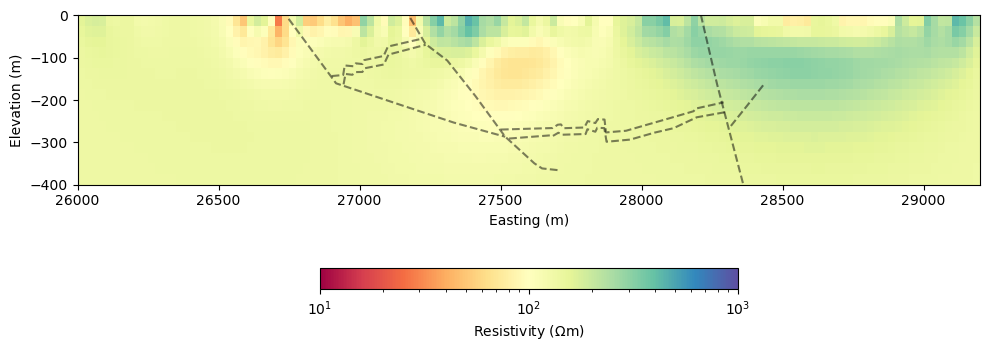

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
rho = (mapping*mopt)
norm = LogNorm(vmin=1e1, vmax=1e3)

out = mesh.plotImage(
    rho, pcolor_opts={'norm':norm, 'cmap':'Spectral'}, ax=ax,
)

for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)

ax.set_xlim(core_domain_x)
ax.set_ylim((-400, 0))
cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax, pad=0.2)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Elevation (m)')
ax.set_aspect(1.5)  # some vertical exxageration
plt.tight_layout()

### Sensitivity analysis

***Get the sensitivity matrix***

In [19]:
simulation_dc._Jmatrix = None # Force computation of new sensitivity matrix
J = simulation_dc.getJ(mopt).copy()

***Average sensitivity***

We use the average sensitivity (Devriese and Oldenburg, 2016).
$$
s_j = \frac{1}{nV_j}\sum_{i=1}^n\left|J_{ij}\right|
$$

In [20]:
Vj = mesh.cell_volumes
n, m = J.shape
sj = np.log10(np.divide(np.sum(abs(J), axis=0), n*Vj))

C:\Users\user\AppData\Local\Temp\ipykernel_11044\3833892129.py:3: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  out = mesh.plotImage(


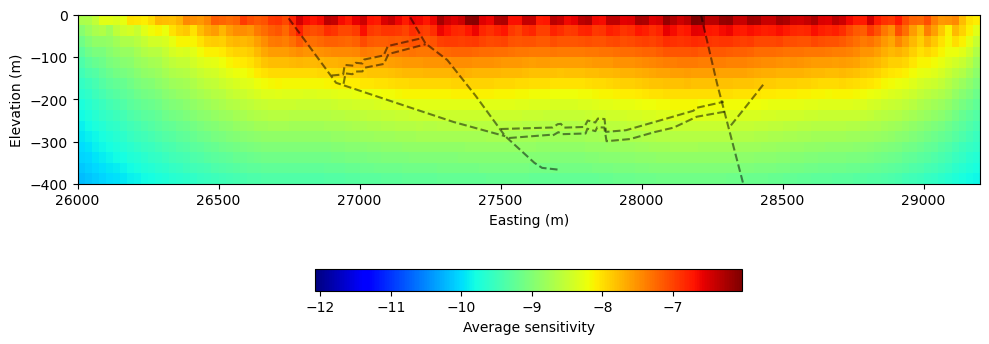

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.jet()
out = mesh.plotImage(
    sj, 
    ax=ax,
)

for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)

ax.set_xlim(core_domain_x)
ax.set_ylim((-400, 0))
cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax, pad=0.2)
cb.set_label("Average sensitivity")
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Elevation (m)')
ax.set_aspect(1.5)  # some vertical exxageration
plt.tight_layout()

## Conclusions

In this tutorial we used the resources avaiable in SimPEG for computing and ploting the sensitivity matrix. We used the DC resistivity problem as a motivation example and analysed the sensitivity patterns for a homogeneous half space using two different survey layouts. We also applied this technique for a DC resistivity real data inversion scenario. This kind of analysis can help us decide upon the most appropriate electrode array to use for a particular exploration project. It is also a valuable tool to have in our toolbox for performing the assessment of the solutions obtained after the application of some inversion algorithm as illustrated by the real case example.

## Acknowledgements

## References

Sarah Devriese and Douglas Oldenburg, (2016), "Application of sensitivity analysis in DC resistivity monitoring of SAGD steam chambers," SEG Technical Program Expanded Abstracts : 937-941. 
https://doi.org/10.1190/segam2016-13842655.1